# Supervised Learning Algorithms
In this notebook, several supervised learning algorithms are used to create binary classifiers that distinguish between benign and malicious traffics in the ids-2017 dataset. Hyperparameters are optimized to obtain a model with the best results and the models are compared

In [1]:
from notebook_utils import load_processed_dataset_2017, plot_confusion_matrix, metrics_report, upsample_dataset, extract_and_plot_metrics
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, average_precision_score, make_scorer, precision_score, accuracy_score, confusion_matrix
from notebook_utils import upsample_dataset
%matplotlib inline
%load_ext autoreload
%autoreload 2
file_path = r"CIC-IDS-2017\CSVs\GeneratedLabelledFlows\TrafficLabelling\processed\ids2017_processed.csv"

In [2]:
X_train, Y_train, X_eval, Y_eval, X_test, Y_test, scaler = load_processed_dataset_2017(file_path)

In [3]:
performance_models = {}

In [4]:
import joblib

def save_model(model, model_name):
    file_path = f'models/{model_name}.pkl'
    joblib.dump(model, file_path)
    print(f'Model saved to {file_path}')

def load_model(model_name):
    file_path = f'models/{model_name}.pkl'
    model = joblib.load(file_path)
    print(f'Model loaded from {file_path}')
    return model

os.makedirs('models', exist_ok=True)

## 1. Naive Bayes

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# Define a small parameter grid
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Initialize the GaussianNB model
nb_model = GaussianNB()

# Initialize GridSearchCV
grid_search_nb = GridSearchCV(estimator=nb_model, param_grid=param_grid_nb, scoring='accuracy', n_jobs=2, cv=2, verbose=2)

# Fit the model on the scaled training data
grid_search_nb.fit(scaler.transform(X_train), Y_train.is_attack)

# Get the best model
best_nb_model = grid_search_nb.best_estimator_
save_model(best_nb_model, 'gaussian_nb_model.pkl')

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Model saved to models/gaussian_nb_model.pkl.pkl


Evaluation Set Performance
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9992    0.4445    0.6153    227310
           1     0.3060    0.9985    0.4685     55764

    accuracy                         0.5537    283074
   macro avg     0.6526    0.7215    0.5419    283074
weighted avg     0.8626    0.5537    0.5864    283074

Accuracy: 0.5536714781293938
Test Set Performance
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9992    0.4421    0.6130    227310
           1     0.3051    0.9986    0.4674     55765

    accuracy                         0.5517    283075
   macro avg     0.6522    0.7203    0.5402    283075
weighted avg     0.8625    0.5517    0.5843    283075

Accuracy: 0.5517018458005829


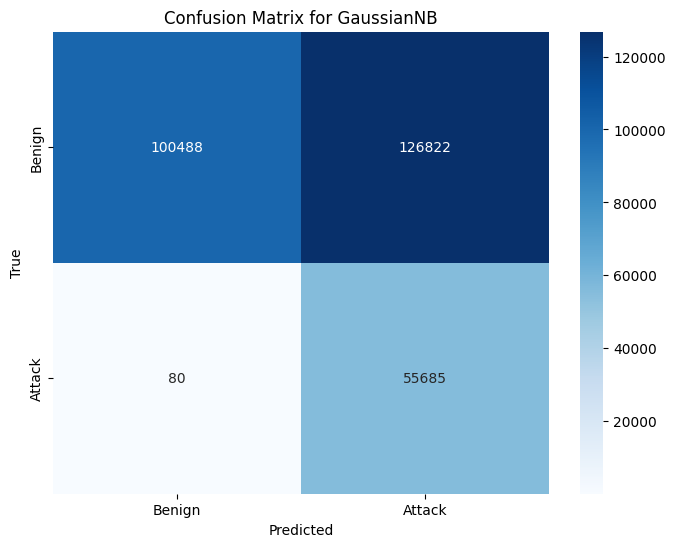

In [6]:
# Predict and evaluate on the evaluation set
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.is_attack, best_nb_model.predict(scaler.transform(X_eval)), print_avg=False)

# Predict and evaluate on the test set
print("Test Set Performance")
Y_pred = best_nb_model.predict(scaler.transform(X_test))
performance_models["GaussianNB"] = metrics_report("Test", Y_test.is_attack, Y_pred, print_avg=False)
plot_confusion_matrix("GaussianNB", Y_test, Y_pred)

In [15]:
performance_models["GaussianNB"] = metrics_report("Test", Y_test.is_attack, Y_pred, print_avg=False)

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9446    0.6808    0.7913    227310
           1     0.3916    0.8373    0.5336     55765

    accuracy                         0.7117    283075
   macro avg     0.6681    0.7591    0.6625    283075
weighted avg     0.8357    0.7117    0.7406    283075

Accuracy: 0.7116559215755541


## 2. K-Nearest Neighbors (KNN)

Evaluation Set Performance
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9735    0.9986    0.9858    227310
           1     0.9934    0.8890    0.9383     55764

    accuracy                         0.9770    283074
   macro avg     0.9834    0.9438    0.9621    283074
weighted avg     0.9774    0.9770    0.9765    283074

Accuracy: 0.9769742187555197
Test Set Performance
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9734    0.9987    0.9859    227310
           1     0.9941    0.8888    0.9385     55765

    accuracy                         0.9771    283075
   macro avg     0.9838    0.9438    0.9622    283075
weighted avg     0.9775    0.9771    0.9766    283075

Accuracy: 0.9770555506491213


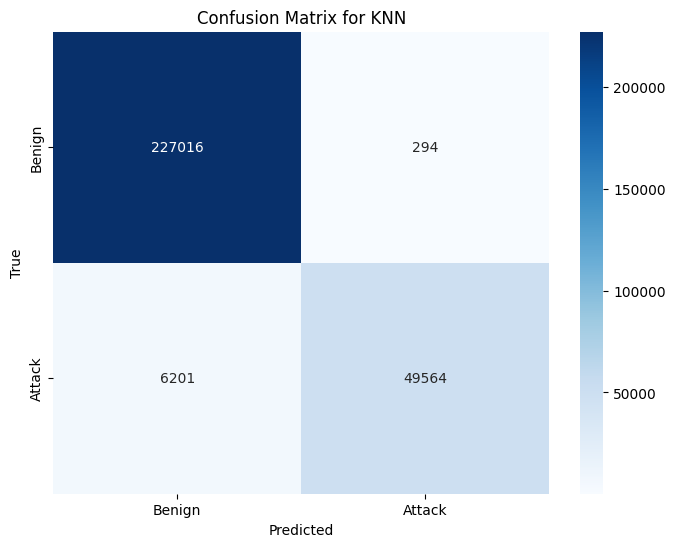

Model saved to models/knn_model.pkl


In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(scaler.transform(X_train), Y_train.is_attack)

# Predict and evaluate on the evaluation set
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.is_attack, knn_model.predict(scaler.transform(X_eval)), print_avg=False)

# Predict and evaluate on the test set
print("Test Set Performance")
Y_pred = knn_model.predict(scaler.transform(X_test))
performance_models["KNN"] = metrics_report("Test", Y_test.is_attack, Y_pred, print_avg=False)
plot_confusion_matrix("KNN", Y_test, Y_pred)

save_model(knn_model, 'knn_model')

In [14]:
performance_models["KNN"] = metrics_report("Test", Y_test.is_attack, Y_pred, print_avg=False)


Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9446    0.6808    0.7913    227310
           1     0.3916    0.8373    0.5336     55765

    accuracy                         0.7117    283075
   macro avg     0.6681    0.7591    0.6625    283075
weighted avg     0.8357    0.7117    0.7406    283075

Accuracy: 0.7116559215755541


## 3. Quadratic Discriminant Analysis (QDA)

In [9]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
# Apply PCA
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(scaler.transform(X_train))
X_eval_pca = pca.transform(scaler.transform(X_eval))
X_test_pca = pca.transform(scaler.transform(X_test))
# Define a small parameter grid
param_grid_qda = {
    'reg_param': [0.0, 0.1, 0.2, 0.3],
    'tol': [1e-4, 1e-5, 1e-6]
}

# Initialize the QDA model
qda_model = QuadraticDiscriminantAnalysis()

# Initialize GridSearchCV with reduced number of folds
grid_search_qda = GridSearchCV(estimator=qda_model, param_grid=param_grid_qda, scoring='accuracy', n_jobs=2, cv=2, verbose=2)

# Fit the model on the PCA-transformed training data
grid_search_qda.fit(X_train_pca, Y_train.is_attack)

# Get the best model
best_qda_model = grid_search_qda.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters for QDA:", grid_search_qda.best_params_)
save_model(best_qda_model, 'qda_model.pkl')

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best Hyperparameters for QDA: {'reg_param': 0.3, 'tol': 0.0001}
Model saved to models/qda_model.pkl.pkl


Evaluation Set Performance
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9444    0.6844    0.7936    227310
           1     0.3938    0.8357    0.5353     55764

    accuracy                         0.7142    283074
   macro avg     0.6691    0.7600    0.6645    283074
weighted avg     0.8359    0.7142    0.7427    283074

Accuracy: 0.7141772116125112
Test Set Performance
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9446    0.6808    0.7913    227310
           1     0.3916    0.8373    0.5336     55765

    accuracy                         0.7117    283075
   macro avg     0.6681    0.7591    0.6625    283075
weighted avg     0.8357    0.7117    0.7406    283075

Accuracy: 0.7116559215755541


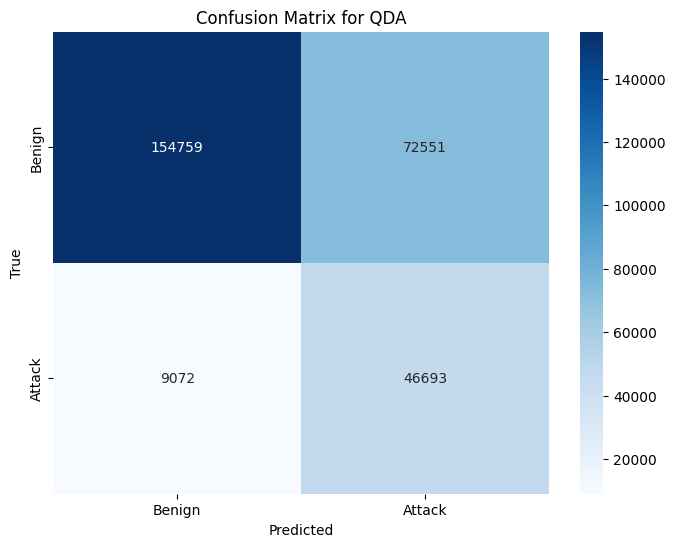

In [10]:
# Predict and evaluate on the evaluation set
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.is_attack, best_qda_model.predict(X_eval_pca), print_avg=False)

# Predict and evaluate on the test set
print("Test Set Performance")
Y_pred = best_qda_model.predict(X_test_pca)
performance_models["QDA"] = metrics_report("Test", Y_test.is_attack, Y_pred, print_avg=False)
plot_confusion_matrix("QDA", Y_test, Y_pred)

## 4. Support Vector Machine

The SVM takes too long with the number of features and number of training examples. PCA components are used to reduce the number of features. 

Model saved to models/linear_svc_binary_pca.pkl
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.8403    0.8796    0.8595    227310
           1     0.3935    0.3186    0.3521     55764

    accuracy                         0.7690    283074
   macro avg     0.6169    0.5991    0.6058    283074
weighted avg     0.7523    0.7690    0.7595    283074

Accuracy: 0.7690497891010831
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.8403    0.8781    0.8588    227310
           1     0.3915    0.3196    0.3519     55765

    accuracy                         0.7681    283075
   macro avg     0.6159    0.5989    0.6053    283075
weighted avg     0.7519    0.7681    0.7589    283075

Accuracy: 0.7681109246666078


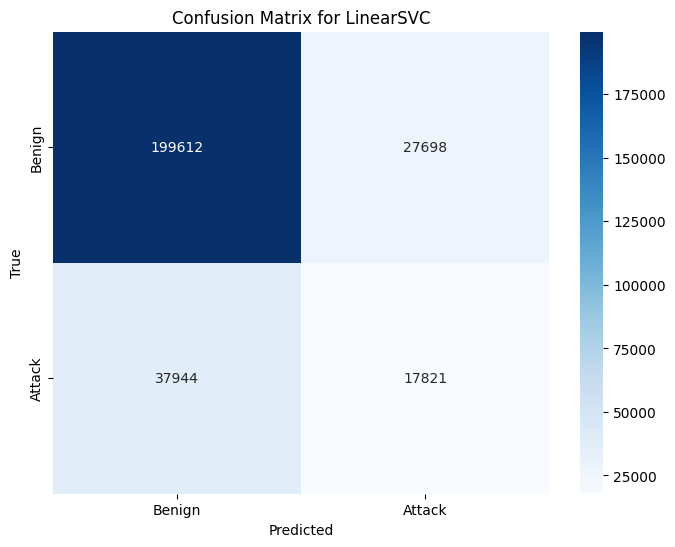

In [11]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
import joblib
import os

# Apply PCA to reduce the number of features
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_eval_pca = pca.transform(X_eval)
X_test_pca = pca.transform(X_test)

# Define the LinearSVC model with chosen hyperparameters
linear_svc_model = LinearSVC(C=1, max_iter=10000, dual="auto")

# Fit the model on the training data
linear_svc_model.fit(X_train_pca, Y_train.is_attack)

# Save the model
save_model(linear_svc_model, 'linear_svc_binary_pca')

# Evaluate the model
# Predict on the evaluation set
y_pred_eval = linear_svc_model.predict(X_eval_pca)
performance_eval = metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test = linear_svc_model.predict(X_test_pca)
performance_models["LinearSVC"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)

# Plot the confusion matrix
plot_confusion_matrix("LinearSVC", Y_test, y_pred_test)

## 5. Conclusion

[0.7116559215755541, 0.7681109246666078, 0.7116559215755541, 0.7116559215755541]
['QDA', 'LinearSVC', 'KNN', 'GaussianNB']


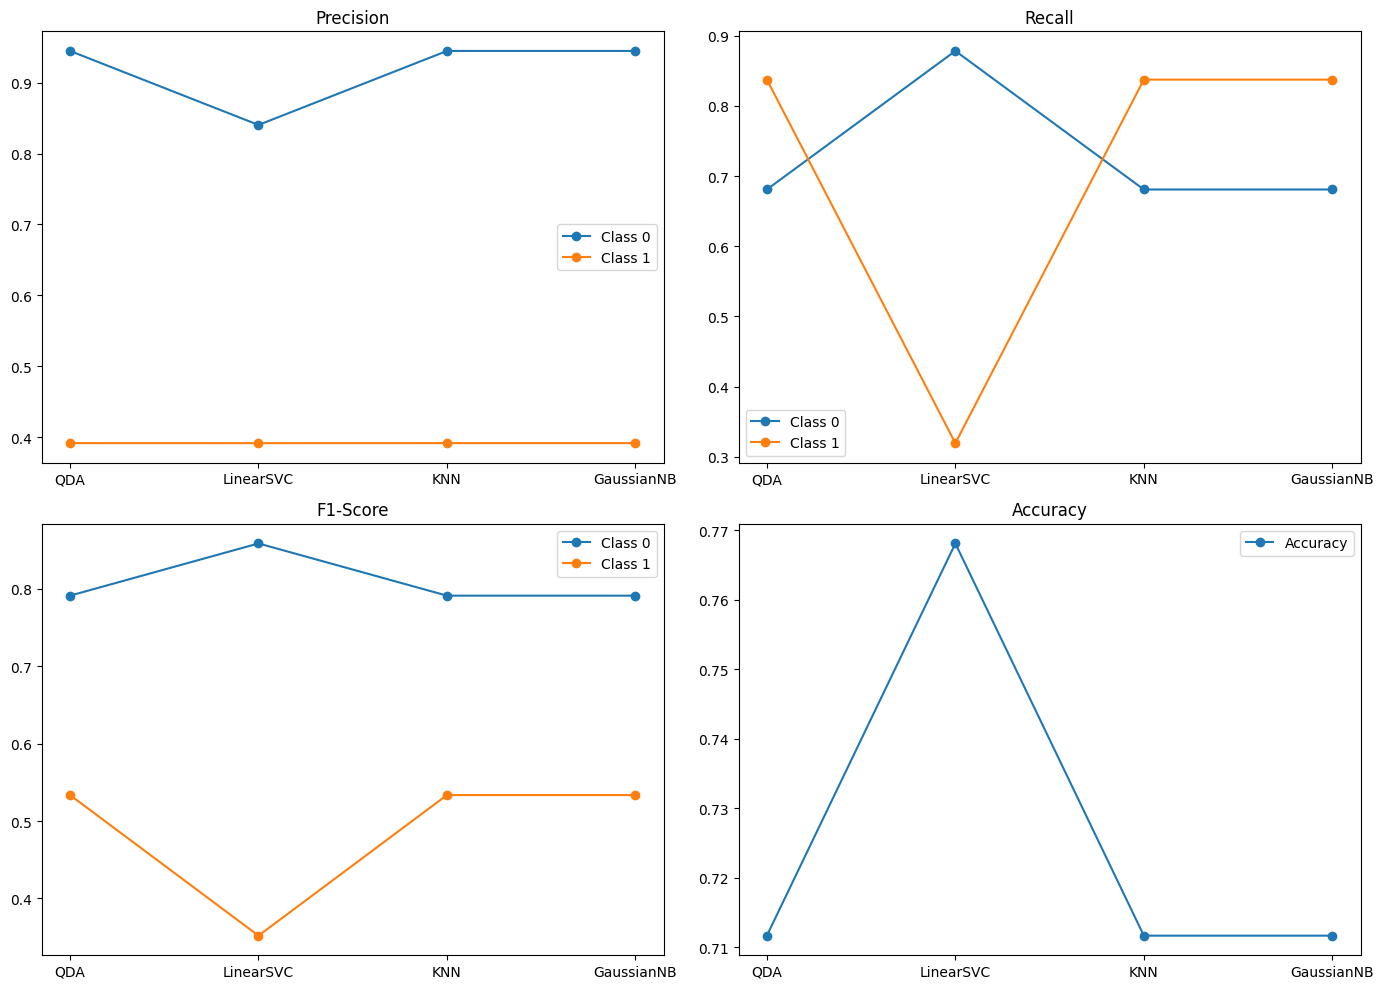

In [16]:
extract_and_plot_metrics(performance_models)

In conclusion, the models used perfrom worse than the tree based and deep neural networks. Therefore, they won't be tested with the ids2018 dataset.